In [47]:
import torch
import utils
import numpy as np
import scanpy as sc
import anndata as ad
from torch import nn
from trainer import concrete_trainer
from network import ConcreteAutoencoder
from sklearn.metrics import adjusted_rand_score
%matplotlib inline

In [26]:
h5ad_path = "../../data/filtered_hg19.h5ad"
device = utils.get_device()
#device = torch.device("cpu")
device


device(type='cuda', index=1)

In [27]:
adata = sc.read_h5ad(h5ad_path )
adata

AnnData object with n_obs × n_vars = 2638 × 3000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [28]:
def get_net(input_dim, k, hidden_dim,out_dim ,device):
    return ConcreteAutoencoder(input_dim, k,hidden_dim,out_dim,device = device)
def load_adata(adata, batch_size):
    return utils.data_loader(adata, batch_size)

In [49]:
num_epoch, learning_rate, weight_dacay, batch_size = 256, 0.001, 0, 128
input_dim = adata.shape[1]
init_temp = 10
end_temp = 0.01
k=384
loss = utils.HurdleLoss()
net = get_net(input_dim=input_dim, k = k, hidden_dim=128, out_dim = input_dim*2, device=device)
dataloader = load_adata(adata=adata, batch_size=batch_size)

In [50]:
concrete_trainer(net=net, loss=loss, dataloader=dataloader,
      num_epoch=num_epoch, learning_rate=learning_rate,
      weight_decay=weight_dacay ,device=device, init_temp=init_temp, 
      end_temp= end_temp)

Epoch: 1 ; Loss: 17238.60742; Temperature: 9.734; Time: 1.12 s
Epoch: 2 ; Loss: 6110.36377; Temperature: 9.475; Time: 2.16 s
Epoch: 3 ; Loss: 4722.48535; Temperature: 9.222; Time: 3.35 s
Epoch: 4 ; Loss: 4602.45117; Temperature: 8.977; Time: 4.52 s
Epoch: 5 ; Loss: 4576.55078; Temperature: 8.738; Time: 5.69 s
Epoch: 6 ; Loss: 4568.02197; Temperature: 8.505; Time: 6.89 s
Epoch: 7 ; Loss: 4563.73438; Temperature: 8.279; Time: 8.04 s
Epoch: 8 ; Loss: 4560.96729; Temperature: 8.058; Time: 9.17 s
Epoch: 9 ; Loss: 4558.91064; Temperature: 7.844; Time: 10.35 s
Epoch: 10 ; Loss: 4557.21533; Temperature: 7.635; Time: 11.54 s
Epoch: 11 ; Loss: 4555.91064; Temperature: 7.432; Time: 12.72 s
Epoch: 12 ; Loss: 4554.53564; Temperature: 7.234; Time: 13.89 s
Epoch: 13 ; Loss: 4553.31689; Temperature: 7.041; Time: 15.10 s
Epoch: 14 ; Loss: 4552.08398; Temperature: 6.854; Time: 16.33 s
Epoch: 15 ; Loss: 4550.79785; Temperature: 6.671; Time: 17.45 s
Epoch: 16 ; Loss: 4549.60791; Temperature: 6.494; Time: 

In [31]:
x_val = torch.Tensor(adata.X.A).to(device) # type: ignore
_, z, m = net(x_val, temperature = end_temp)
z = z.to('cpu').detach().numpy()
m = m.to('cpu').detach().numpy()
res_adata = ad.AnnData(z)
res_adata.shape

(2638, 512)

In [ ]:
res_adata.write_h5ad("./output/concrete_autoencoder.h5ad")

In [32]:
sc.tl.pca(res_adata, svd_solver='arpack')


/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


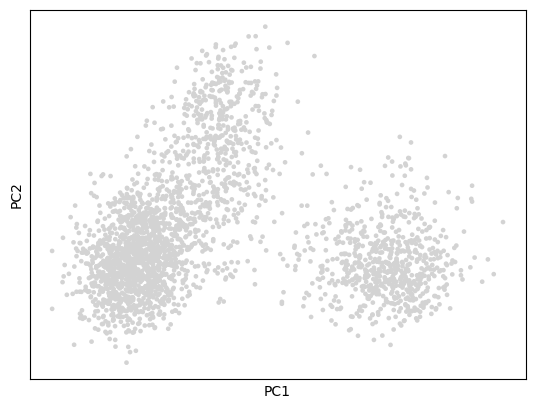

In [33]:
sc.pl.pca(res_adata)

In [34]:
sc.pp.neighbors(res_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(res_adata)

/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


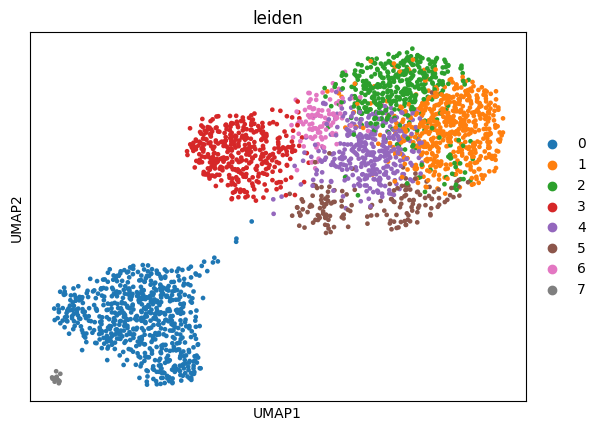

In [37]:
sc.tl.leiden(res_adata,resolution=0.92)
sc.pl.umap(res_adata, color='leiden')

In [38]:
res_adata

AnnData object with n_obs × n_vars = 2638 × 512
    obs: 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [48]:
ari = adjusted_rand_score(adata.obs['leiden'], res_adata.obs['leiden'])
ari

0.3438396593882911

In [43]:
max_idx = []
for i in range(m.shape[1]):
    max_idx.append(np.argmax(m[:,i]))


In [ ]:
def find_same(index):
    count = 0
    for i in range(1,len(index)):
        for j in range(i):
            if index[j] == index[i]:
                count +=1
    print(count)  

In [ ]:
max_idx

In [ ]:
res_adata

In [44]:
res_genes = adata.var_names[max_idx]

In [45]:
res_adata.var_names = res_genes # type: ignore

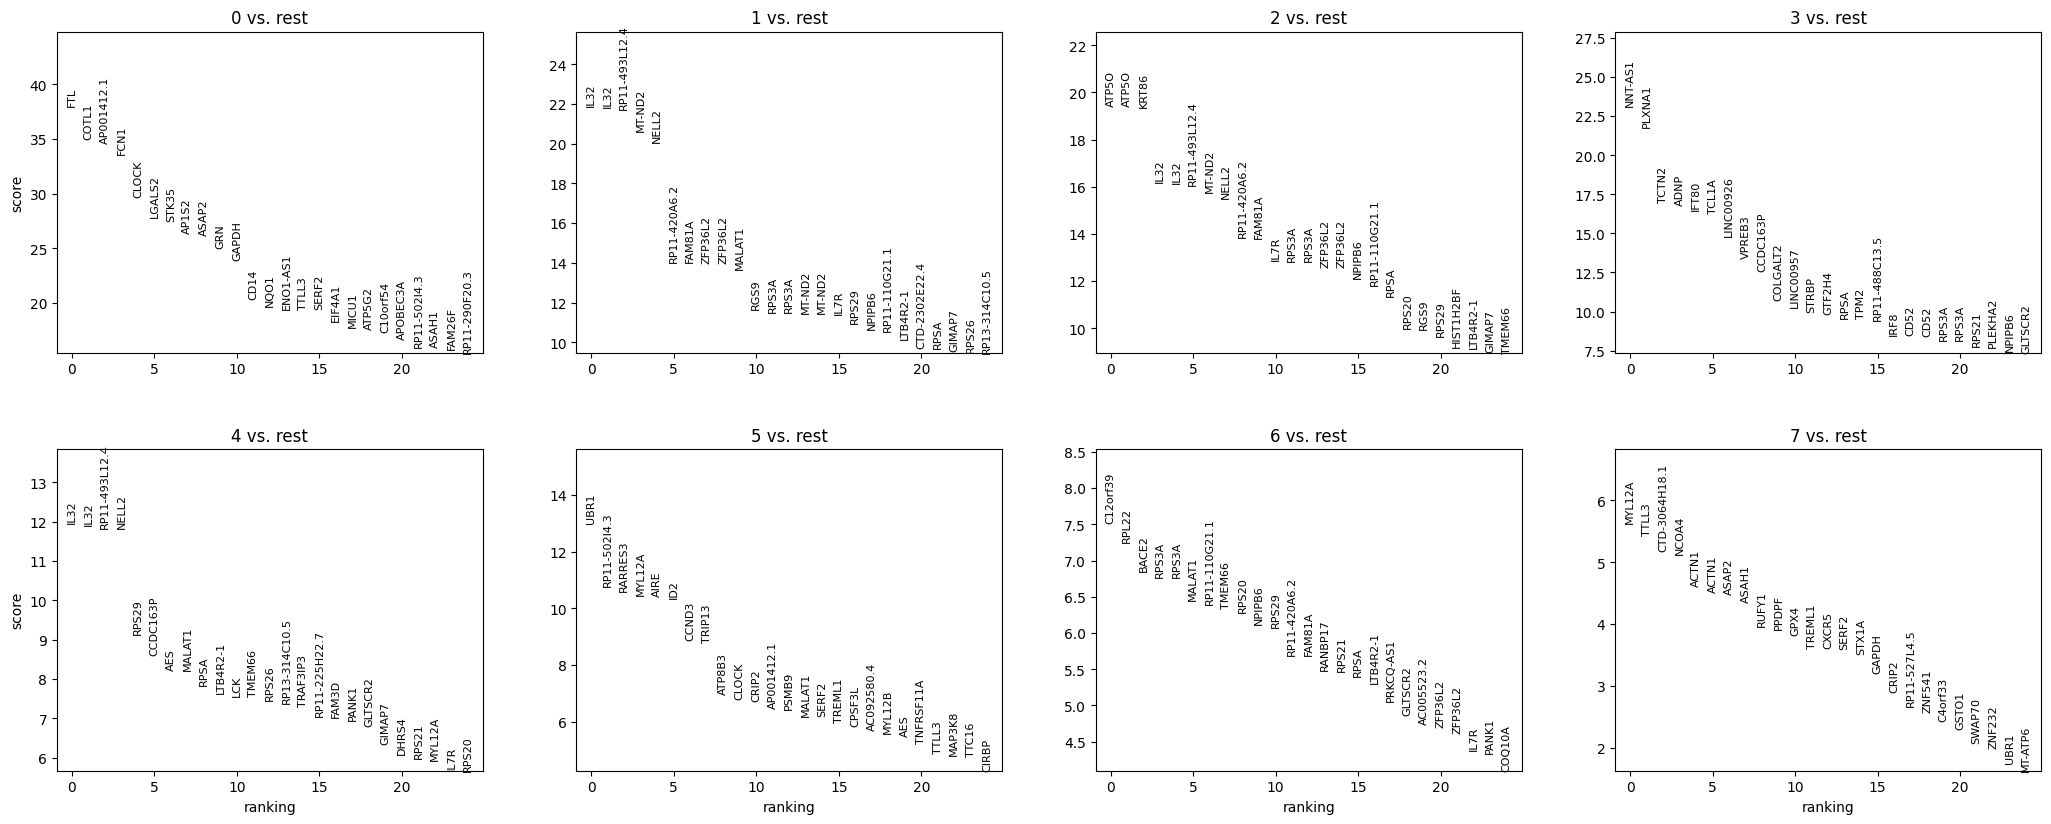

In [46]:
sc.tl.rank_genes_groups(res_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(res_adata, n_genes=25, sharey=False)

In [ ]:
adata = utils.anndata_load(file_path=file_path)
adata = utils.anndata_preprocess(adata=adata,n_top_genes=1000)

In [ ]:
var_genes = adata.var_names

In [ ]:
res_adata.var_names_make_unique()

In [ ]:
s = set(res_adata.var_names)

In [ ]:
temp1 = [x for x in var_genes if x not in s]

In [ ]:
selected_tf = np.zeros([10,10])
for i in range(10):
    net = get_net(input_dim=input_dim, k=10, hidden_dim=128, device=device)
    dataloader = load_adata(adata=tf_adata, batch_size=batch_size)
    concrete_trainer(net=net, loss=loss, dataloader=dataloader,
      num_epoch=num_epoch, learning_rate=learning_rate,
      weight_decay=weight_dacay ,device=device, init_temp=init_temp, 
      end_temp= end_temp)
    x_val = torch.Tensor(tf_adata.X.A[:,0:-1]).to(device)
    _, z, m = net(x_val, temperature = end_temp)
    m = m.to('cpu').detach().numpy()
    selected_tf[i] = np.argmax(m,axis=0)
selected_tf
idx, freq = np.unique(selected_tf, return_counts=True)
idx, freq
idx = idx[np.argsort(freq)][::-1].astype(int)
tf_adata.var_names[idx]

In [ ]:
num_epoch, learning_rate, weight_dacay, batch_size = 200, 0.001, 0, 256
input_dim = adata.shape[1]
init_temp = 10
end_temp = 0.01
k=384
loss = utils.HurdleLoss()
selected_geneset = []
x_val = torch.Tensor(adata.X.A).to(device) # type: ignore
for i in range(32):
  net = get_net(input_dim=input_dim, k = k, hidden_dim=256, out_dim = input_dim*2, device=device)
  dataloader = load_adata(adata=adata, batch_size=batch_size)
  concrete_trainer(net=net, loss=loss, dataloader=dataloader,num_epoch=num_epoch, learning_rate=learning_rate,
    weight_decay=weight_dacay ,device=device, init_temp=init_temp, 
    end_temp= end_temp)
  _, _, m = net(x_val, temperature = end_temp)
  m = m.to('cpu').detach().numpy()
  for i in range(m.shape[1]):
    selected_geneset.append(np.argmax(m[:,i]))


In [ ]:
len(selected_geneset)

In [ ]:
geneset = np.unique(selected_geneset, return_counts=True)

In [ ]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

In [ ]:
geneset.columns = ['gene_idx','count']
geneset

In [ ]:
geneset.to_csv('../result/geneset384.csv',index=False)

In [ ]:
filtered_set = geneset.sort_values(by='count',ascending=False).head(100)

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
l1=ax1.plot(err_list,'g-',label = 'loss')
l2=ax2.plot(temp_list,'b--',label = 'temperature')
plt.title("Concrete Autoencoder Model Training, k=384")
ax1.set_xlabel('epoch')
ax2.set_ylabel('temperature')
ax1.set_ylabel('loss')
lb = l1 + l2
labs = [l.get_label() for l in lb]
ax1.legend(lb, labs, loc=0)
plt.savefig("concrete_autoencoder_k384.pdf")

In [ ]:
filtered_set

In [ ]:
gene_set = pd.read_csv('../result/geneset384.csv')
filtered_set = gene_set.sort_values(by='count',ascending=False).head(384)

In [ ]:
x = range(len(filtered_set))
y = filtered_set['count'].values / 32
label = adata.var_names[filtered_set['gene_idx'].values]

In [ ]:
plt.figure(figsize=(12.8,7.2))
plt.bar(x,y,tick_label=label)
plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Frequency')
plt.ylim(0.2,0.7)
plt.title('Top 50 genes selected by Concrete Autoencoder')
#plt.savefig('../result/selected_geneset384_top50.pdf',bbox_inches='tight')

In [ ]:
subset = adata.X[:,filtered_set['gene_idx'].values]
adata_subset = ad.AnnData(subset)
adata_subset.var_names = label

In [ ]:
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pl.pca(adata_subset)

In [ ]:
sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_subset)

In [ ]:
sc.tl.leiden(adata_subset,resolution=1)
sc.pl.umap(adata_subset, color='leiden')

In [ ]:
sc.tl.rank_genes_groups(adata_subset, 'leiden', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata_subset, n_genes=25, sharey=False,save = 'rank_genes_groups_1.pdf')

In [ ]:
diff_gene = ['FTH1', 'S100A6','RPS3A', 'CD79A','CD74','CD2','CTSW','LTB', 'RPS27A','RPL13','ACTB']

In [ ]:
sc.pl.dotplot(adata_subset, diff_gene, groupby='leiden',save='dotplot_1.pdf')

In [ ]:
result = adata_subset.uns['rank_genes_groups']
groups = result['names'].dtype.names
gene_pvalue= pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

In [ ]:
gene_pvalue.to_csv('../result/gene_pvalue.csv',index=False)

In [ ]:
max_idx